In [1]:
import joblib

!sha1sum "../data/dyn_kvlist_3dyns.joblib" \
         "../data/sem_charlist.joblib"
kv_list = joblib.load("../data/dyn_kvlist_3dyns.joblib")
sem_charlist = joblib.load("../data/sem_charlist.joblib")


e7ca62ab6a722b1b18c2bcddccdedc16e157666e  ../data/dyn_kvlist_3dyns.joblib
acae09913848583e794dcba628a88650b23f2f41  ../data/sem_charlist.joblib


In [2]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")
from dietcoke.vocab import DummyVocab
from dietcoke.metrics import compute_nearestN_metrics_full
import random
import numpy as np
import numpy.linalg as la
from tqdm.auto import tqdm

No author time map ...


In [3]:
def post_process_semlist(sem_charlist, do_permute, random_seed):

    if do_permute:
        rng = random.Random(random_seed)
        ## permute the sem_charlist
        sem_idxs = list(range(len(sem_charlist)))
        pho_idxs = list(range(len(sem_charlist)))
        rng.shuffle(sem_idxs)
        rng.shuffle(pho_idxs)
        perm_charlist = []
        
        for i in range(len(sem_charlist)):
            perm_charlist.append((
                sem_charlist[i][0], 
                sem_charlist[sem_idxs[i]][1], 
                sem_charlist[pho_idxs[i]][2]))
        sem_charlist = perm_charlist
  
    print("# of sem_charlist: ", len(sem_charlist))
    print("sem_charlist[:3]: ", sem_charlist[:3])
    
    return sem_charlist


In [4]:
def residual_radical_model(
        dyn_kv,
        sem_charlist,     
        do_permutation,    
        random_seed
    ):  
    
    # only keep those are in dyn_kv
    sem_charlist = [x for x in sem_charlist 
                    if x[0] in dyn_kv]
    
    sem_charlist = post_process_semlist(
                  sem_charlist,                   
                  do_permutation, 
                  random_seed)
    
    ## compute radical frequencies
    sem_rad_map = {}
    pho_rad_map = {}
    for c, s, p in sem_charlist:
        sem_rad_map.setdefault(s, []).append(c)
        pho_rad_map.setdefault(p, []).append(c)
        sem_freq = {s: len(cs) for s, cs in sem_rad_map.items()}
        pho_freq = {p: len(cs) for p, cs in pho_rad_map.items()}

    ## how many hapax in sem and phono?
    sem_hapax = [s for s, f in sem_freq.items() if f == 1]
    pho_hapax = [p for p, f in pho_freq.items() if f == 1]
    # print the length along with percentage
    print("Sem hapax: %d (%.2f)" % (len(sem_hapax), len(sem_hapax)/len(sem_rad_map)))
    print("Pho hapax: %d (%.2f)" % (len(pho_hapax), len(pho_hapax)/len(pho_rad_map)))

    char_vocab = np.array([x[0] for x in sem_charlist])
    char_emb = np.vstack([
        dyn_kv.get_vector(c[0], norm=False) 
        for c in sem_charlist
        ])

    # %%
    sem_rad_vocab = DummyVocab()
    pho_rad_vocab = DummyVocab()
    for c, s, p in sem_charlist:
        sem_rad_vocab.get_index(s)
        pho_rad_vocab.get_index(p)

    nchar = len(sem_charlist)
    semM = np.zeros((nchar, len(sem_rad_vocab)))
    phoM = np.zeros((nchar, len(pho_rad_vocab)))
    for i, (c, s, p) in enumerate(sem_charlist):
        semM[i, sem_rad_vocab.get_index(s)] = 1
        phoM[i, pho_rad_vocab.get_index(p)] = 1


    print("semM, phoM shape: %s, %s" % (semM.shape, phoM.shape))

    semM_pinv = la.pinv(semM)
    phoM_pinv = la.pinv(phoM)

    ## Residual model      
    sem_emb = semM_pinv @ char_emb
    pho_emb = phoM_pinv @ (char_emb-semM @ sem_emb)
    pred_emb = semM @ sem_emb + phoM @ pho_emb
    residual = char_emb - pred_emb    

    ## Evaluations
    ff = lambda x: [round(y,4) for y in x]
    full_eval = compute_nearestN_metrics_full(pred_emb, char_emb, n_neighbors=20)
    full_accs = full_eval[0]
    # print("full prediction: %s, %s" % (ff(full_accs[:3]), ff(full_accs[-3:])))

    return dict(
        random_seed=random_seed,        
        do_permutation=do_permutation,        
        states=dict(
          sem_charlist=sem_charlist,
          sem_rad_vocab=sem_rad_vocab,
          pho_rad_vocab=pho_rad_vocab,
          char_vocab=char_vocab,
          semM=semM,
          phoM=phoM,
          sem_emb=sem_emb, 
          pho_emb=pho_emb,
          res_pred_emb=pred_emb,
          residual=residual,
        ),
        accs = dict(
          full=np.array(full_accs),
        )
    )

In [5]:
kv0 = kv_list[0]["kv"]
kv1 = kv_list[1]["kv"]
kv2 = kv_list[2]["kv"]
print("----", kv_list[0]["note"], "----\n")
print(">>> Empirical <<<")
dyn0_emp = residual_radical_model(kv0, sem_charlist, do_permutation=False, random_seed=123)
print(">>> Permutation <<<")
dyn0_perm = residual_radical_model(kv0, sem_charlist, do_permutation=True, random_seed=123)

print("\n----", kv_list[1]["note"], "----\n")
print(">>> Empirical <<<")
dyn1_emp = residual_radical_model(kv1, sem_charlist, do_permutation=False, random_seed=123)
print(">>> Permutation <<<")
dyn1_perm = residual_radical_model(kv1, sem_charlist, do_permutation=True, random_seed=123)

print("\n----", kv_list[2]["note"], "----\n")
print(">>> Empirical <<<")
dyn2_emp = residual_radical_model(kv2, sem_charlist, do_permutation=False, random_seed=123)
print(">>> Permutation <<<")
dyn2_perm = residual_radical_model(kv2, sem_charlist, do_permutation=True, random_seed=123)

---- dynasty_split/先秦.jsonl ----

>>> Empirical <<<
# of sem_charlist:  3309
sem_charlist[:3]:  [('的', '白_⿰0', '勺_⿰1'), ('了', '亅_⿱1', '乛_⿱0'), ('和', '口_⿰1', '禾_⿰0')]
Sem hapax: 148 (0.42)
Pho hapax: 1285 (0.67)
semM, phoM shape: (3309, 354), (3309, 1922)
>>> Permutation <<<
# of sem_charlist:  3309
sem_charlist[:3]:  [('的', '糹_⿰0', '禺_⿺1'), ('了', '言_⿰0', '米_⿸1'), ('和', '田_⿰0', '于_⿰1')]
Sem hapax: 148 (0.42)
Pho hapax: 1285 (0.67)
semM, phoM shape: (3309, 354), (3309, 1922)

---- dynasty_split/漢.jsonl ----

>>> Empirical <<<
# of sem_charlist:  4396
sem_charlist[:3]:  [('的', '白_⿰0', '勺_⿰1'), ('了', '亅_⿱1', '乛_⿱0'), ('第', '竹_⿱0', '𢎨_⿱1')]
Sem hapax: 183 (0.45)
Pho hapax: 1499 (0.64)
semM, phoM shape: (4396, 409), (4396, 2325)
>>> Permutation <<<
# of sem_charlist:  4396
sem_charlist[:3]:  [('的', '冂_⿻0', '毛_⿸1'), ('了', '辶_⿺0', '俞_⿰1'), ('第', '口_⿰0', '其_⿰1')]
Sem hapax: 183 (0.45)
Pho hapax: 1499 (0.64)
semM, phoM shape: (4396, 409), (4396, 2325)

---- dynasty_split/魏晉南北.jsonl ----

>>> Emp

## Plotting

Text(0.5, 1.0, 'Char Emb. prediction across dynasties')

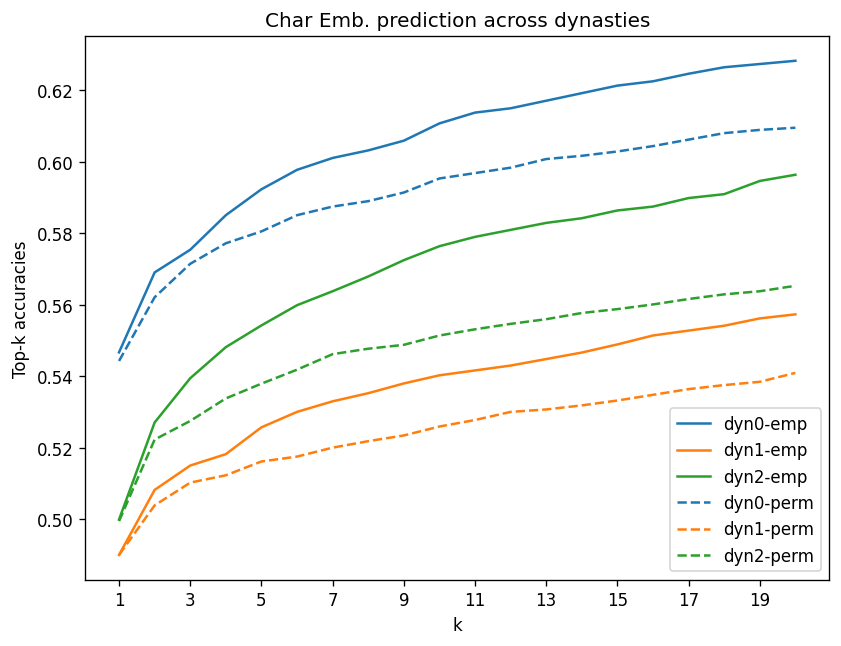

In [6]:
# get default matplotlib colormap
import matplotlib.pyplot as plt

cmap = plt.get_cmap("tab10")
LINESTYLE_A = "solid"
LINESTYLE_B = "dashed"
plt.figure(figsize=(8,6), dpi=120)
plt.plot(dyn0_emp["accs"]["full"], label="dyn0-emp", 
         linestyle=LINESTYLE_A, color=cmap(0))
plt.plot(dyn1_emp["accs"]["full"], label="dyn1-emp", 
         linestyle=LINESTYLE_A, color=cmap(1))
plt.plot(dyn2_emp["accs"]["full"], label="dyn2-emp", 
         linestyle=LINESTYLE_A, color=cmap(2))
plt.plot(dyn0_perm["accs"]["full"], label="dyn0-perm", 
         linestyle=LINESTYLE_B, color=cmap(0))
plt.plot(dyn1_perm["accs"]["full"], label="dyn1-perm", 
         linestyle=LINESTYLE_B, color=cmap(1))
plt.plot(dyn2_perm["accs"]["full"], label="dyn2-perm", 
         linestyle=LINESTYLE_B, color=cmap(2))

plt.xlabel("k")
plt.ylabel("Top-k accuracies")
plt.xticks(ticks=np.arange(0, 20, 2), labels=np.arange(0,20,2)+1)
plt.legend()
plt.title("Char Emb. prediction across dynasties")

Text(0.5, 1.0, 'Prediction effect across dynasties')

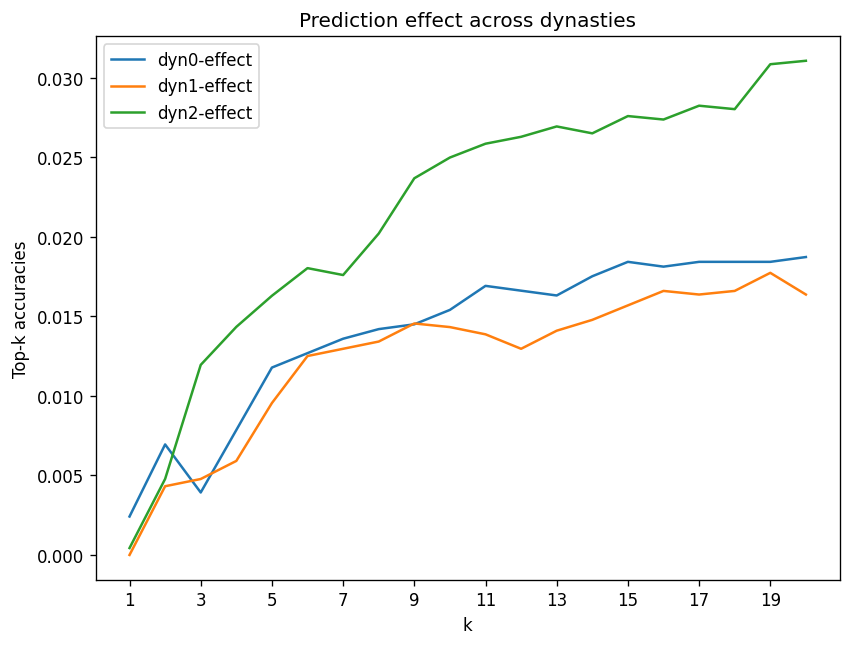

In [7]:
# get default matplotlib colormap
import matplotlib.pyplot as plt

cmap = plt.get_cmap("tab10")
LINESTYLE_A = "solid"
LINESTYLE_B = "dashed"

plt.figure(figsize=(8,6), dpi=120)
plt.plot(dyn0_emp["accs"]["full"]-dyn0_perm["accs"]["full"], 
         label="dyn0-effect", 
         linestyle=LINESTYLE_A, color=cmap(0))
plt.plot(dyn1_emp["accs"]["full"]-dyn1_perm["accs"]["full"], 
         label="dyn1-effect", 
         linestyle=LINESTYLE_A, color=cmap(1))
plt.plot(dyn2_emp["accs"]["full"]-dyn2_perm["accs"]["full"], 
         label="dyn2-effect", 
         linestyle=LINESTYLE_A, color=cmap(2))

plt.xlabel("k")
plt.ylabel("Top-k accuracies")
plt.xticks(ticks=np.arange(0, 20, 2), labels=np.arange(0,20,2)+1)
plt.legend()
plt.title("Prediction effect across dynasties")